# Machine Learning inside of Pipline

[Recently, we presented](https://www.quantopian.com/posts/machine-learning-on-quantopian) how to load alpha signals into a research notebook, preprocess them, and then train a Machine Learning classifier to predict future returns. This was done in a static fashion, meaning we loaded data once over a fixed period of time (using the `run_pipeline()` command), split into test and train, and predicted inside of the research notebook.

This leaves open the question of how to move this workflow to a trading algorithm, where `run_pipeline()` is not available. Here we show how you can move your ML steps into a pipeline `CustomFactor` where the classifier gets retrained periodically on the most recent data and predicts returns. This is still not moving things into a trading algorithm, but it gets us one step closer.

If you haven't yet, definitely read the notebook on the [static workflow](https://www.quantopian.com/posts/machine-learning-on-quantopian) first. We will be reusing the same concepts and code but not re-explain the logic of preprocessing the data.

### Disclaimer

This workflow is still a bit rough around the edges. We are working on improving it and adding better educational materials. This serves as a sneak-peek for the curious and adventurous.

In [1]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Latest
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor, SimpleMovingAverage, AverageDollarVolume, Returns, RSI
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import Q500US, Q1500US
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from quantopian.pipeline.data.zacks import EarningsSurprises

import talib
import pandas as pd
import numpy as np
from time import time

import alphalens as al
import pyfolio as pf
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

## Definition of some commonly used factors

The factors below are a small collection of commonly used alphas that were coded by Gil Wassermann. I will post a separate Notebook with the full collection and more descriptions of them. Ultimately we will put these into a library you can just import to avoid the wall of text. If you want to understand more about pipeline, read the [tutorial](https://www.quantopian.com/tutorials/pipeline).

In [2]:
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios


def make_factors():
    def Asset_Growth_3M():
        return Returns(inputs=[bs.total_assets], window_length=63)

    def Asset_To_Equity_Ratio():
        return bs.total_assets.latest / bs.common_stock_equity.latest

    def Capex_To_Cashflows():
        return (cfs.capital_expenditure.latest * 4.) / \
            (cfs.free_cash_flow.latest * 4.)
        
    def EBITDA_Yield():
        return (is_.ebitda.latest * 4.) / \
            USEquityPricing.close.latest        

    def EBIT_To_Assets():
        return (is_.ebit.latest * 4.) / \
            bs.total_assets.latest
        
    def Earnings_Quality():
        return morningstar.cash_flow_statement.operating_cash_flow.latest / \
               EarningsSurprises.eps_act.latest
        
    def Return_On_Total_Invest_Capital():
        return or_.roic.latest
    
    class Mean_Reversion_1M(CustomFactor):
        inputs = [Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
                
    class MACD_Signal_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    _, signal_line, _ = talib.MACD(col, fastperiod=12,
                                                   slowperiod=26, signalperiod=10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines 
            
    class Moneyflow_Volume_5d(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.volume]
        window_length = 5

        def compute(self, today, assets, out, close, volume):

            mfvs = []

            for col_c, col_v in zip(close.T, volume.T):

                # denominator
                denominator = np.dot(col_c, col_v)

                # numerator
                numerator = 0.
                for n, price in enumerate(col_c.tolist()):
                    if price > col_c[n - 1]:
                        numerator += price * col_v[n]
                    else:
                        numerator -= price * col_v[n]

                mfvs.append(numerator / denominator)
            out[:] = mfvs  
            
           
    def Net_Income_Margin():
        return or_.net_margin.latest           

    def Operating_Cashflows_To_Assets():
        return (cfs.operating_cash_flow.latest * 4.) / \
            bs.total_assets.latest

    def Price_Momentum_3M():
        return Returns(window_length=63)
    
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            four_week_period = close[-20:]
            out[:] = (np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.
    
    def Returns_39W():
        return Returns(window_length=215)
    
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
        
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
    def Working_Capital_To_Assets():
        return bs.working_capital.latest / bs.total_assets.latest
        
    all_factors = {
        'Asset Growth 3M': Asset_Growth_3M,
        'Asset to Equity Ratio': Asset_To_Equity_Ratio,
        'Capex to Cashflows': Capex_To_Cashflows,
        'EBIT to Assets': EBIT_To_Assets,
        'EBITDA Yield': EBITDA_Yield,        
        'Earnings Quality': Earnings_Quality,
        'MACD Signal Line': MACD_Signal_10d,
        'Mean Reversion 1M': Mean_Reversion_1M,
        'Moneyflow Volume 5D': Moneyflow_Volume_5d,
        'Net Income Margin': Net_Income_Margin,        
        'Operating Cashflows to Assets': Operating_Cashflows_To_Assets,
        'Price Momentum 3M': Price_Momentum_3M,
        'Price Oscillator': Price_Oscillator,
        'Return on Invest Capital': Return_On_Total_Invest_Capital,
        '39 Week Returns': Returns_39W,
        'Trendline': Trendline,
        'Vol 3M': Vol_3M,
        'Working Capital to Assets': Working_Capital_To_Assets,        
    }        
    
    return all_factors

<a id='universe'></a>

## Define universe and select factors to use

We will screen our universe using the new [Q1500US](https://www.quantopian.com/posts/the-q500us-and-q1500us) and hand-pick a few alphas from the list above. We encourage you to play around with the factors.

In [3]:
universe = Q1500US()

factors = make_factors()

##Define helper functions

In [4]:
n_fwd_days = 5 # number of days to compute returns over

In [5]:
def shift_mask_data(X, Y, upper_percentile=70, lower_percentile=30, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days:]
    Y = Y[n_fwd_days:]
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
  
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 1
    Y_binary[lower_mask.flatten()] = -1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are in the 30th to 70th percentile)
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    return X, Y_binary

def get_last_values(input_data):
    last_values = []
    for dataset in input_data:
        last_values.append(dataset[-1])
    return np.vstack(last_values).T

## Define the Machine Learning Pipeline Factor

Where before we called `run_pipeline()` to get our data and then train a ML model on the `DataFrame` we received, we now move this step into a Pipeline Factor as well. The steps taken are the same, first we make the factor values match up with the future returns, we binarize the returns, and then impute and scale. Note that we retrain the model only weekly but certainly that's a choice you have to make.

The same factor then also does prediction. For that we call the `.predict_proba()` method which returns a probability of the stock going up. Ultimately, this output will feed into the next stage: portfolio construction. 

In [6]:
class ML(CustomFactor):
    init = False

    def compute(self, today, assets, out, returns, *inputs):
        # inputs is a list of factors, for example, assume we have 2 alpha signals, 3 stocks,
        # and a lookback of 2 days. Each element in the inputs list will be data of
        # one signal, so len(inputs) == 2. Then each element will contain a 2-D array
        # of shape [time x stocks]. For example:
        # inputs[0]:
        # [[1, 3, 2], # factor 1 rankings of day t-1 for 3 stocks  
        #  [3, 2, 1]] # factor 1 rankings of day t for 3 stocks
        # inputs[1]:
        # [[2, 3, 1], # factor 2 rankings of day t-1 for 3 stocks
        #  [1, 2, 3]] # factor 2 rankings of day t for 3 stocks
        
        if (not self.init) or (today.weekday == 0): # Monday
            # Instantiate sklearn objects
            self.imputer = preprocessing.Imputer()
            self.scaler = preprocessing.MinMaxScaler()
            self.clf = ensemble.AdaBoostClassifier(n_estimators=100)
            
            # Stack factor rankings
            X = np.dstack(inputs) # (time, stocks, factors)
            Y = returns # (time, stocks)
        
            # Shift data to match with future returns and binarize 
            # returns based on their 
            X, Y = shift_mask_data(X, Y, n_fwd_days)
            
            X = self.imputer.fit_transform(X)            
            X = self.scaler.fit_transform(X)
            
            # Fit the classifier
            self.clf.fit(X, Y)
            
            self.init = True

        # Predict
        # Get most recent factor values (inputs always has the full history)
        last_factor_values = get_last_values(inputs)
        last_factor_values = self.imputer.transform(last_factor_values)
        last_factor_values = self.scaler.transform(last_factor_values)

        # Predict the probability for each stock going up 
        # (column 2 of the output of .predict_proba()) and
        # return it via assignment to out.
        out[:] = self.clf.predict_proba(last_factor_values)[:, 1]

In [7]:
from collections import OrderedDict

def make_ml_pipeline(factors, universe, window_length=30, n_fwd_days=5):
    factors_pipe = OrderedDict()
    # Create returns over last n days.
    factors_pipe['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    # Instantiate ranked factors
    for name, f in factors.iteritems():
        factors_pipe[name] = f().rank(mask=universe)
        
    # Create our ML pipeline factor. The window_length will control how much
    # lookback the passed in data will have.
    factors_pipe['ML'] = ML(inputs=factors_pipe.values(), 
                            window_length=window_length + 1, 
                            mask=universe)
    
    pipe = Pipeline(screen=universe, columns=factors_pipe)
    
    return pipe

In [8]:
ml_pipe = make_ml_pipeline(factors, universe)

In [9]:
start_timer = time()
start = pd.Timestamp("2015-01-01") # Can't choose a much longer time-period or we run out of RAM
end = pd.Timestamp("2016-03-01")

results = run_pipeline(ml_pipe, start_date=start, end_date=end)

end_timer = time()

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [10]:
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 446.68 secs


What happened here?

Our complete pipeline was run every day with the current data (look-ahead bias free). Every Monday we preprocessed the data and trained a classifier. We then used that classifier for predictions on subsequent days.

The 'ML' column will contain for each day, the predicted probabilities of each stock to go up, relative to the other ones in the universe. From here we could create a portfolio inside of an algorithm and trade into it. We will show this step in a future post. Lets examine what the output looks like:

In [11]:
results['ML'].head()

2015-01-02 00:00:00+00:00  Equity(2 [AA])       0.502363
                           Equity(24 [AAPL])    0.499659
                           Equity(41 [ARCB])    0.504887
                           Equity(62 [ABT])     0.502039
                           Equity(67 [ADSK])    0.497456
Name: ML, dtype: float64

In [12]:
results['ML'].tail()

2016-03-01 00:00:00+00:00  Equity(49229 [KHC])     0.503767
                           Equity(49242 [PYPL])    0.505316
                           Equity(49496 [FDC])     0.499979
                           Equity(49506 [HPE])     0.500321
                           Equity(49630 [CSRA])    0.503846
Name: ML, dtype: float64

## Analyzing our mega-alpha with pipeline

It's important to realize that our predictions are just another alpha signal (one that is hopefully more predictive than each individual signal in isolation). Because of that, we can analyze just like any other alpha signal with [AlphaLens](https://www.quantopian.com/posts/alphalens-a-new-tool-for-analyzing-alpha-factors).

First, we need to get the pricing data.

In [13]:
assets = results.index.levels[1]
pricing = get_pricing(assets, start, end + pd.Timedelta(days=30), fields="open_price")

Then call `create_factor_tear_sheet()` with our factor and the pricing data:

Returns Analysis


,1,5,10
Ann. alpha,0.000,-0.000,-0.000
beta,-0.001,-0.002,-0.002
Mean Daily Return Top Quantile (bps),2.283,1.401,0.843
Mean Daily Return Bottom Quantile (bps),-2.351,-0.469,0.359
Mean Daily Spread (bps),4.633,1.852,0.471


Information Analysis


,1,5,10
IC Mean,0.014,0.023,0.024
IC Std.,0.130,0.141,0.141
t-stat(IC),1.877,2.845,2.889
p-value(IC),0.062,0.005,0.004
IC Skew,0.073,-0.394,-0.511
IC Kurtosis,-0.332,0.083,-0.317
Ann. IR,1.744,2.643,2.684


Turnover Analysis


,Top Quantile,Bottom Quantile
Mean Turnover,0.364,0.311


,
Mean Factor Rank Autocorrelation,0.796


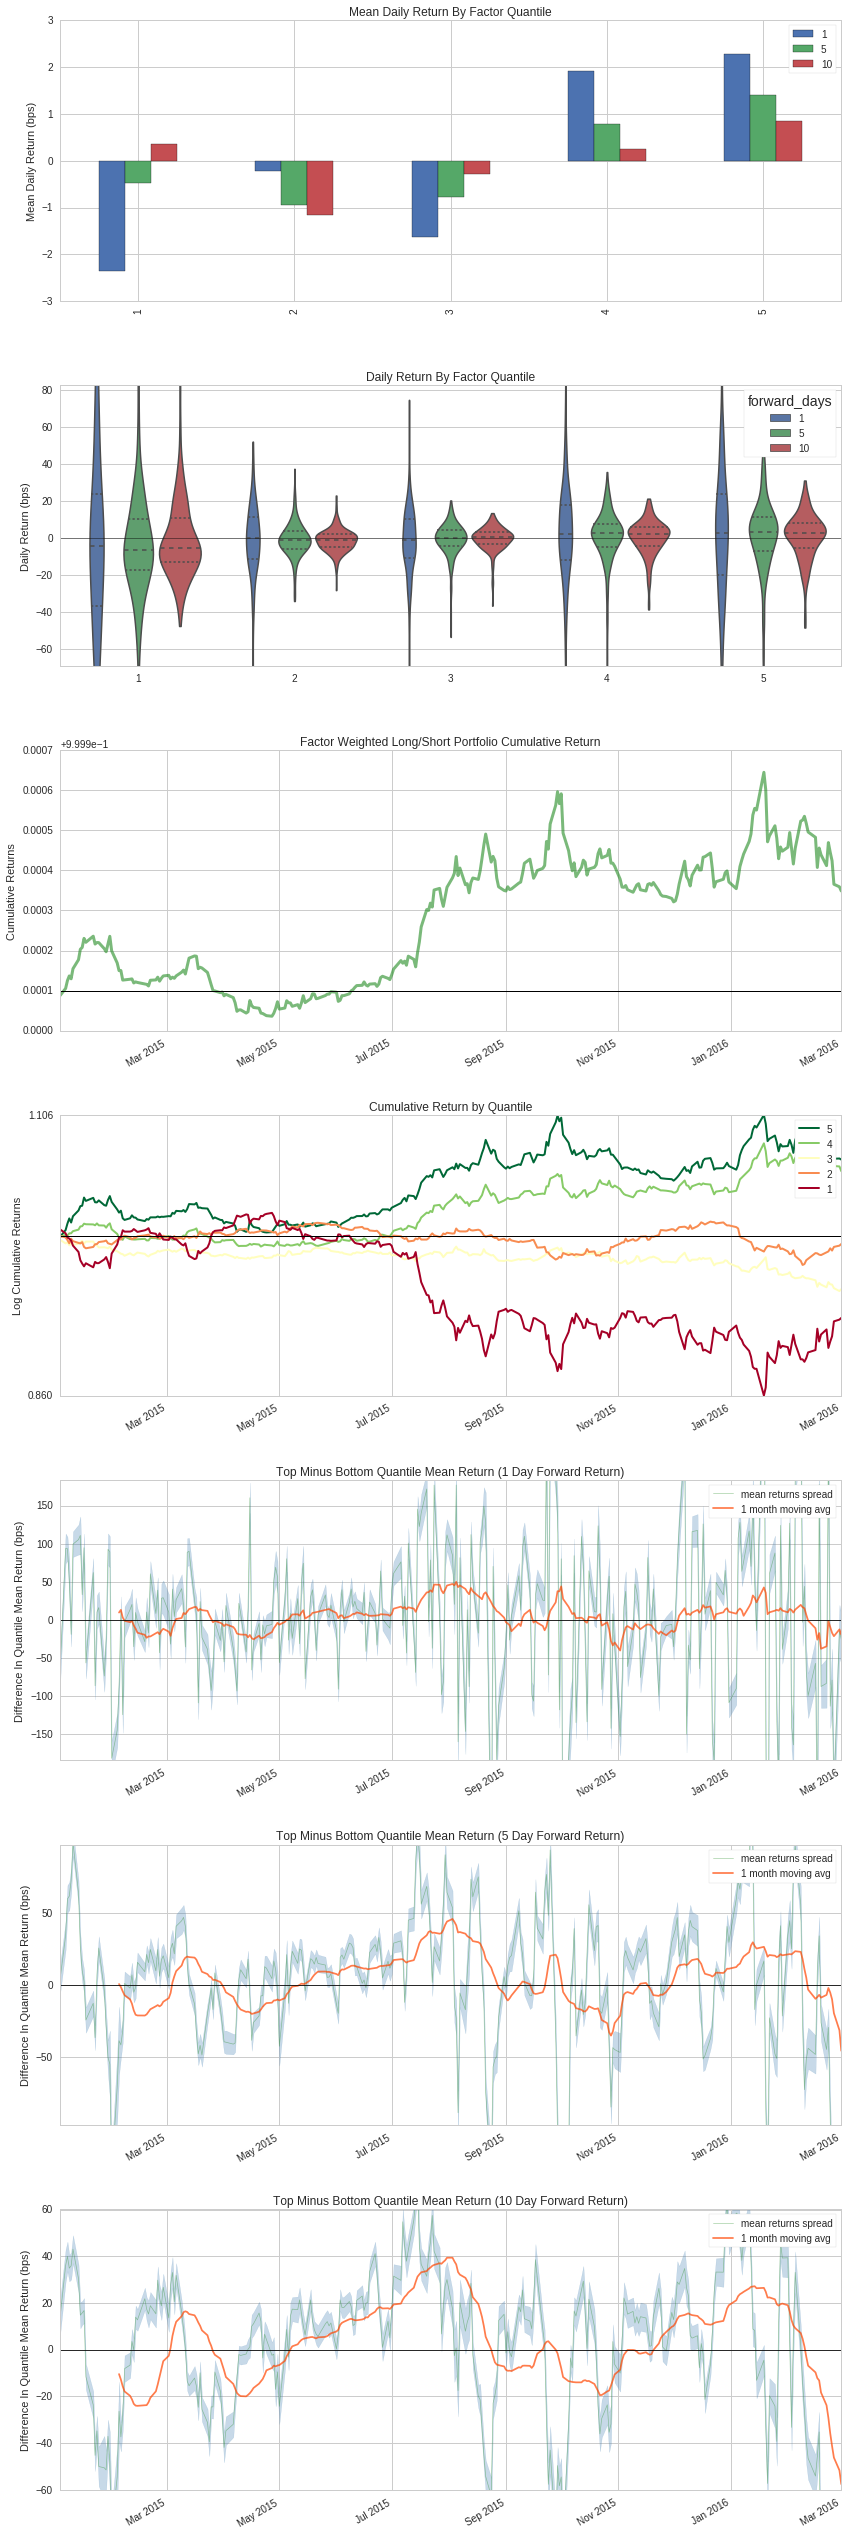

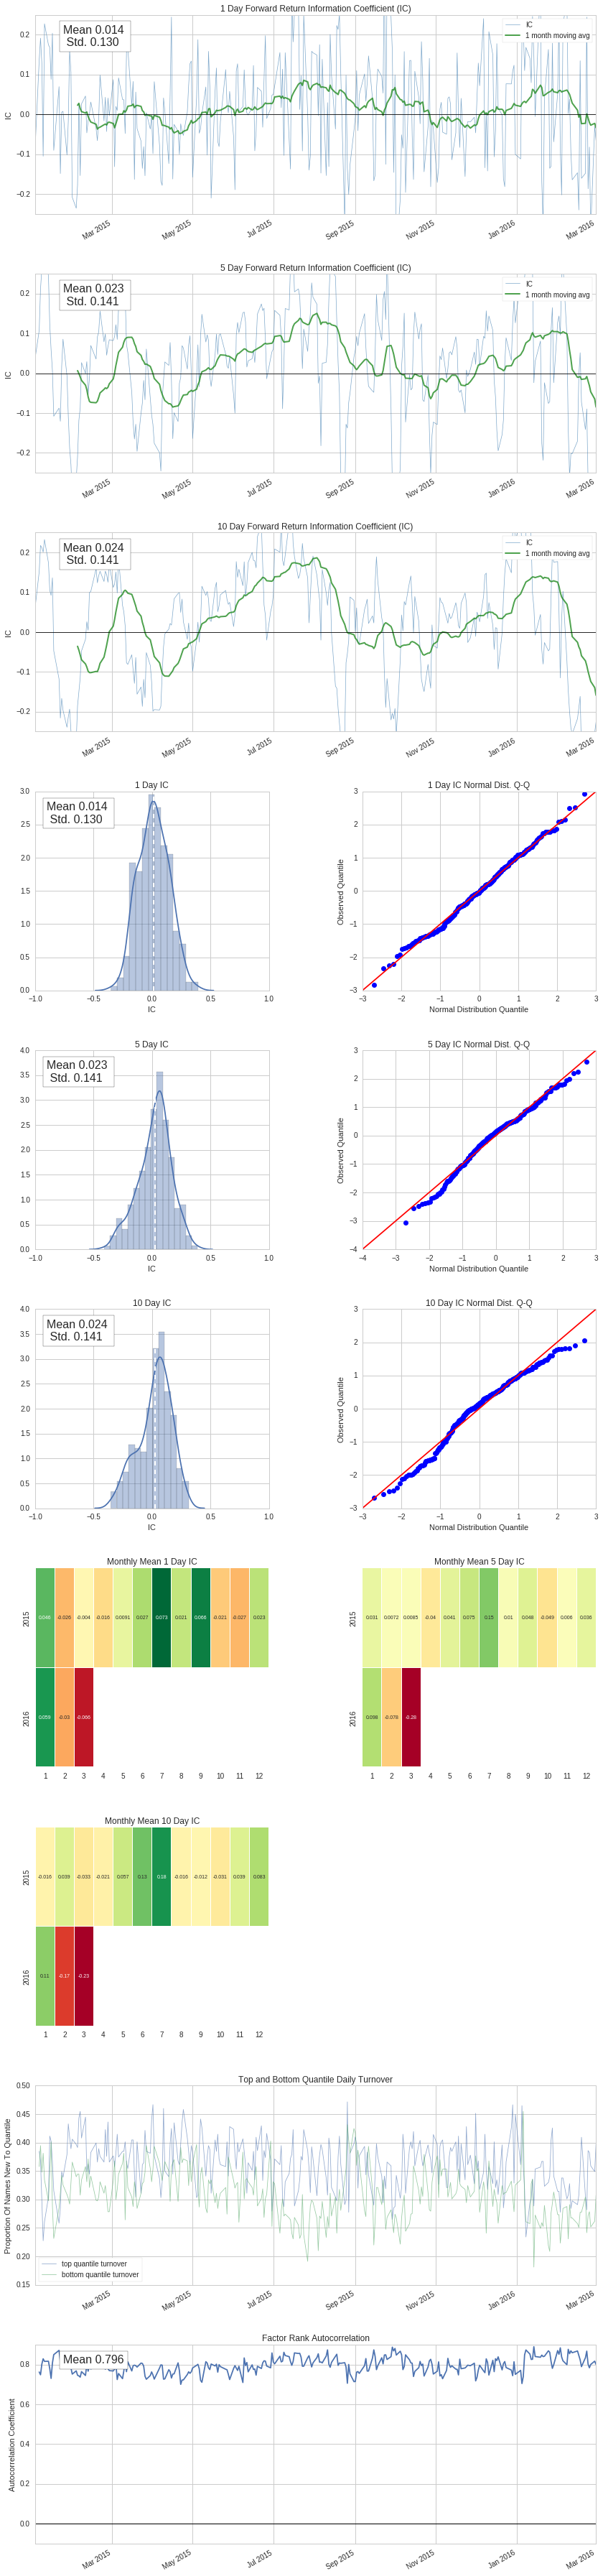

In [14]:
al.tears.create_factor_tear_sheet(results['ML'], pricing)

We see a pretty nice separation of the stocks where low probabilities (low quantiles) are associated with negative future returns and high probabilities (high quantiles) are associated with positive future returns. This is completely look-ahead bias free as we never used any future data to train the model.

Note that I picked a time range that worked pretty well. The tear sheet does not look as good in the more recent past.

## Credits
By Thomas Wiecki & James Christopher.

Thanks to Scott Sanderson for useful discussions, building pipeline, and for making it more memory efficient. Thanks to Jamie McCorriston and Max Margenot for feedback on an earlier draft.